In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import numpy as np
import cvxpy as cp

from scipy import stats
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import random

import sys
sys.path.insert(0, './mlopt-micp')
sys.path.insert(0, './mlopt-micp/cartpole')

import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

import optimizer
from problem import Cartpole
from src.ae import Encoder, get_cartpole_encoder

In [3]:
pp = Cartpole()

In [179]:
test_start = int(0.99*pp.n_probs)
n_test = int(0.01*pp.n_probs)

In [5]:
#compute strategy dictionary for all problems
pp.training_batch_percentage = 1.
pp.construct_strategies()
strat_lookup = {}
for k, v in pp.strategy_dict.items():
    strat_lookup[v[0]] = v[1:]

# MLOPT

In [6]:
fn_classifier_model = 'pytorch/mlopt_model_cartpole_20200610_1131_classifier.pt'
if os.path.exists(fn_classifier_model):
    pp.model_classifier.load_state_dict(torch.load(fn_classifier_model))

In [87]:
mlopt_feasible = np.zeros(n_test)
mlopt_costs = np.zeros(n_test)
mlopt_costs_ratio = np.zeros(n_test)

In [88]:
prob_success = False

for ii in range(n_test):
    try:
        prob_success, cost, solve_time, n_evals = pp.solve_with_classifier(ii+test_start)
        if prob_success:
            mlopt_feasible[ii] = 1.
            mlopt_costs[ii] = cost
            mlopt_costs_ratio[ii] = cost / pp.J[ii+test_start]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('mosek failed at '.format(ii))

# CoCO

In [22]:
dim_in, dim_z = pp.n_features, 2
enc = get_cartpole_encoder(dim_in, dim_z).cuda()
m = 250

In [23]:
coco_model = 'pytorch/coco-{}strats.pt'.format(m)
if os.path.exists(coco_model):
    enc.load_state_dict(torch.load(coco_model))

In [27]:
centroids = 10*torch.randn(m,dim_z).cuda()
tau = 1.

feats = torch.from_numpy(pp.features).float().cuda()

enc_dict = {}
str_dict = {}
for ii in range(len(pp.features)):
    str_idx = int(pp.labels[ii,0])
    str_dict[ii] = str_idx
    if str_idx in enc_dict.keys():
        enc_dict[str_idx] += [ii]
    else:
        enc_dict[str_idx] = [ii]

max_inds = np.argsort(np.array([len(e) for e in enc_dict.values()]))[-m:]

n_train_strategies = m #store how many strats in train set
c_k = torch.zeros((n_train_strategies,dim_z)) 
embeddings = enc(feats) #embed training points
for ii in range(n_train_strategies): #compute train centroids
    inds = enc_dict[max_inds[ii]]
    c_k[ii,:] = torch.mean(embeddings[inds,:],axis=0).cuda()

#setup for test
test_feats = torch.from_numpy(pp.features[int(0.9*pp.n_probs):,:]).float().cuda()
test_enc = enc(test_feats).cuda()
test_dists = torch.cdist(test_enc,c_k.cuda()).detach().cpu().numpy()
ind_max = np.argsort(test_dists)[:,:pp.n_evals]

In [98]:
coco_feasible = np.zeros(n_test)
coco_costs = np.zeros(n_test)
coco_costs_ratio = np.zeros(n_test)

In [99]:
for ii in range(n_test):
    for jj in range(pp.n_evals):
        y_guess = strat_lookup[max_inds[ind_max[ii,jj]]]
        try:
            prob_success, cost, solve_time = pp.solve_mlopt_prob_with_idx(ii+test_start, y_guess)
            if prob_success:
                coco_feasible[ii] = 1.
                coco_costs[ii] = cost
                coco_costs_ratio[ii] = cost / pp.J[ii+test_start]
                break
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('mosek failed at '.format(ii))

# kNN

In [47]:
def nn_classifier(x,Y,k=1):
    dist_inds = torch.argsort(torch.cdist(Y,x[None,:]),dim=0).cpu().numpy()
    strats_sorted = pp.labels[dist_inds,0].astype(int)
    return int(stats.mode(strats_sorted[:k])[0])

In [70]:
Y = feats[:test_start,:]

nn_classifier(feats[test_start,:],Y,k=5)

k = 5

In [71]:
knn_feasible = np.zeros(n_test)
knn_costs = np.zeros(n_test)
knn_costs_ratio = np.zeros(n_test)

In [72]:
prob_success = False

for ii in range(n_test):
    y_guess = strat_lookup[nn_classifier(feats[test_start+ii,:],Y,k=k)]
    try:
        prob_success, cost, solve_time = pp.solve_mlopt_prob_with_idx(ii+test_start, y_guess)
        if prob_success:
            knn_feasible[ii] = 1.
            knn_costs[ii] = cost
            knn_costs_ratio[ii] = cost / pp.J[ii+test_start]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('mosek failed at '.format(ii))

# Results

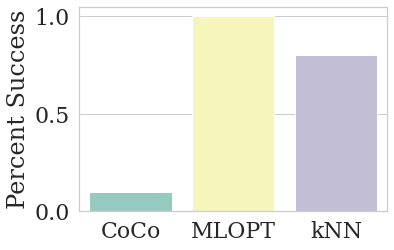

In [147]:
results = pd.DataFrame()
results['Policy'] = ['CoCo',  'MLOPT', 'kNN']
results['Success'] = [np.sum(coco_feasible) / len(coco_feasible), np.sum(mlopt_feasible) / len(mlopt_feasible), np.sum(knn_feasible) / len(knn_feasible)]

ax1 = sns.barplot(x=results['Policy'], y=results['Success'], palette="Set3")

ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("percent_success.pdf")

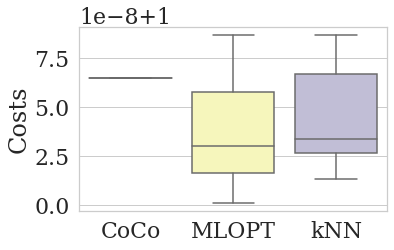

In [178]:
coco_feasible_cost_ratios = [coco_costs_ratio[ii] for ii in range(n_test) if coco_feasible[ii]]
mlopt_feasible_cost_ratios = [mlopt_costs_ratio[ii] for ii in range(n_test) if mlopt_feasible[ii]]
knn_feasible_cost_ratios = [knn_costs_ratio[ii] for ii in range(n_test) if knn_feasible[ii]]

results = pd.DataFrame()
results['Costs'] = coco_feasible_cost_ratios + mlopt_feasible_cost_ratios + knn_feasible_cost_ratios
results['Policy'] = ['CoCo']*len(coco_feasible_cost_ratios) +   ['MLOPT']*len(mlopt_feasible_cost_ratios) + ['kNN']*len(knn_feasible_cost_ratios)

ax2 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3")
ax2.set(xlabel="", ylabel="Costs")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(coco_feasible_cost_ratios, mlopt_feasible_cost_ratios, knn_feasible_cost_ratios)) / 10.0)) * 10)

figure = ax2.get_figure()
# figure.savefig("costs.pdf")